In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [4]:
%load_ext autoreload
%autoreload 2
from preprocessing import *

/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [5]:
from sklearn import cluster
import sklearn

In [7]:
def compute_jaccard_affinity_matrix(object_id,exclude_lst=[]):
    bb_objects = bb_info[bb_info["object_id"]==object_id]
    worker_lst =  bb_objects.worker_id.unique()
    worker_lst = [w for w in worker_lst if w not in exclude_lst]
    prj_matrix = []
    for idx in worker_lst:
        prj_row =[]
        for jdx in worker_lst:
            #if idx!=jdx :
                worker_BB_polygon = worker_polygon(bb_objects,idx)
                worker_BB_polygon2 = worker_polygon(bb_objects,jdx)
                prj = BB_PRJ(worker_BB_polygon,worker_BB_polygon2)
                prj_row.append(prj[2])
        prj_matrix.append(prj_row)
    prj_matrix = np.array(prj_matrix)
    worker_lst=np.array(worker_lst)
    return prj_matrix,worker_lst

In [6]:
spectral = cluster.SpectralClustering(
        n_clusters=2, eigen_solver='arpack',
        affinity="precomputed")

obj=8
aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)

In [6]:
def plot_and_compute_laplacian_eigenval(obj,aff_mat,labelledN):
    tmp_arr = []
    for row in aff_mat:
        tmp_arr.append(sum(row))
    diag = np.eye(len(tmp_arr))
    for i in range(len(tmp_arr)):
        diag[i][i] = tmp_arr[i]
    lapl = np.zeros_like(diag)
    lapl = diag - aff_mat
    eigenval = np.linalg.eigvals(lapl)
    plt.figure()
    plt.title("Obj {} [labelled N={}]".format(obj,labelledN))
    plt.plot(sorted(eigenval),'o')
    return eigenval

obj 47 (3 cluster)

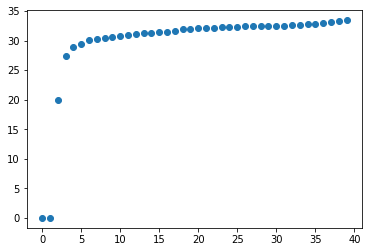

In [83]:
plt.plot(sorted(eigenval),'o')

obj 30 (2 cluster)

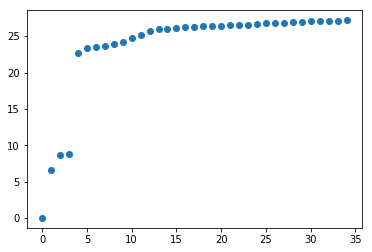

In [78]:
plt.plot(sorted(eigenval),'o')

obj 31 (3 cluster)

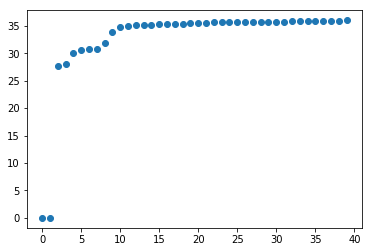

In [73]:
plt.plot(sorted(eigenval),'o')

In [54]:
def run_spectral_clustering(obj,N,PLOT=True):
    spectral = cluster.SpectralClustering(
            n_clusters=N, eigen_solver='arpack',
            affinity="precomputed")
    aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)
    labels = spectral.fit_predict(aff_mat)
    obj_worker_cluster =[]
    if PLOT: 
        bb_objects = bb_info[bb_info["object_id"]==obj]
        plt.figure()
        plt.title("Obj {}".format(obj))
#         colors = ["blue","red","green","magenta","orange"]
#         for i,ylabel in enumerate(list(set(labels))):
        cmap = plt.cm.rainbow
        for i,ylabel in enumerate(list(set(labels))):
            c = cmap(i / float(len(list(set(labels)))))
            workers_in_cluster = np.where(labels==ylabel)[0]
            for widx in workers_in_cluster:
                plot_coords(worker_polygon(bb_objects,worker_lst[widx]),reverse_xy=True,color=c,fill_color="")
        plot_coords(ground_truth_T(obj),color="black",fill_color="",reverse_xy=True,lw=3,linestyle='--',invert_y=True)
        plot_and_compute_laplacian_eigenval(obj,aff_mat,N)
        
    for i,ylabel in enumerate(list(set(labels))):
        workers_in_cluster = np.where(labels==ylabel)[0]
        for widx in workers_in_cluster:
            obj_worker_cluster.append([obj,worker_lst[widx],ylabel])
    return obj_worker_cluster

# Given manually labelled number of clusters, KMeans does very well except for obj 18, 29, 47

In [50]:
objN_lst = [(1,2),(4,2),(7,2),(8,3),(10,2),(20,5),(15,2),(18,4),(21,2),(22,3),(25,2),(26,2),(27,4),(28,2),(29,3),(30,2),(31,3),(32,2),(33,2),(34,2),(35,2),(37,2),(40,2),(42,2),(47,3)]

In [51]:
#old # objN_lst = [(1,2),(4,2),(7,2),(8,3),(10,2),(20,4),(15,2),(18,3),(20,4),(21,3),(22,4),(25,2),(26,2),(27,4),(28,2),(29,3),(30,2),(31,3),(32,2),(33,2),(34,3),(35,2),(37,2),(40,2),(42,2),(47,2)]

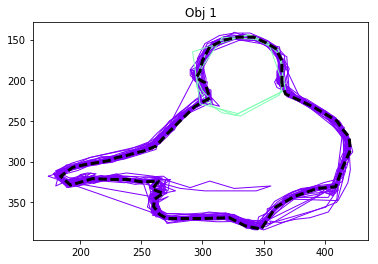

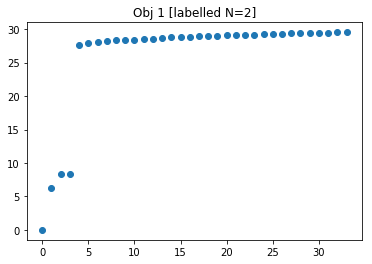

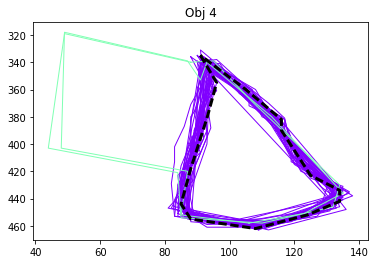

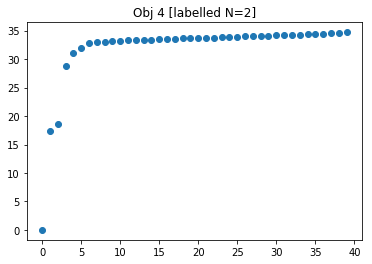

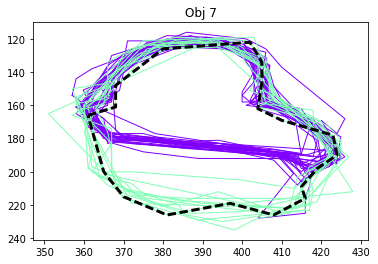

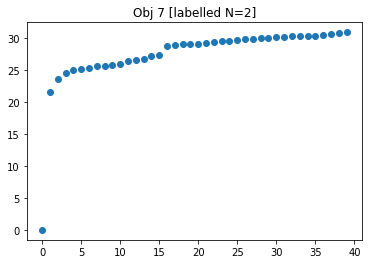

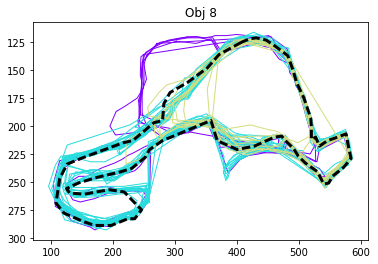

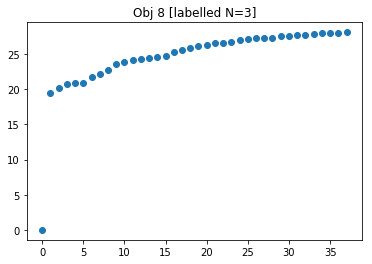

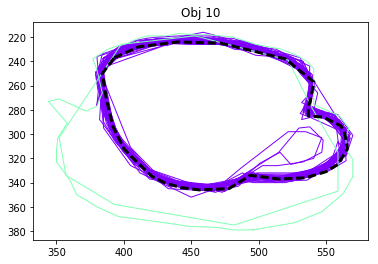

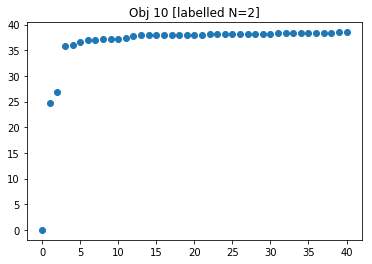

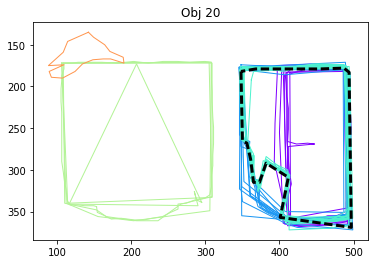

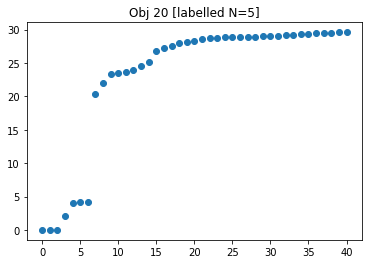

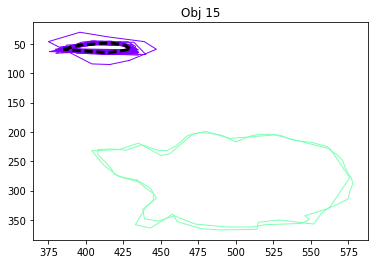

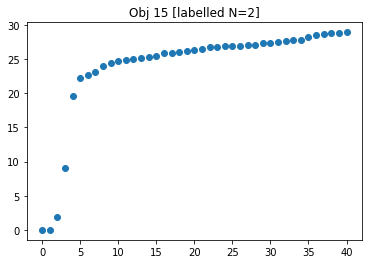

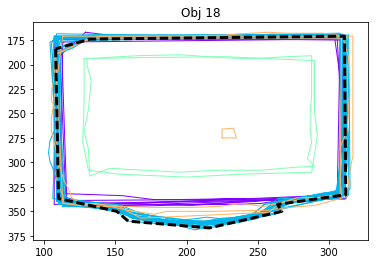

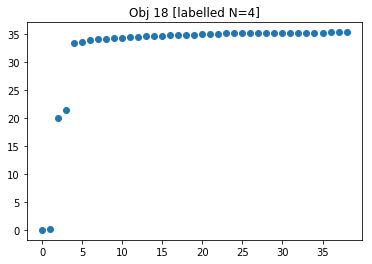

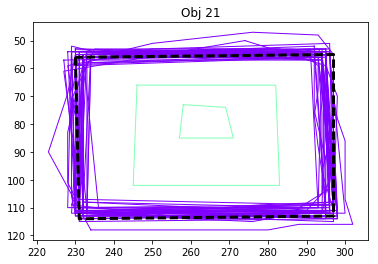

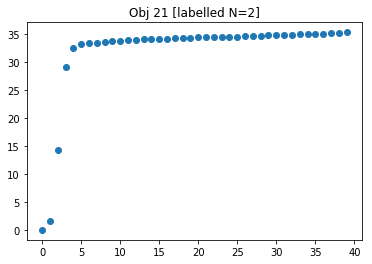

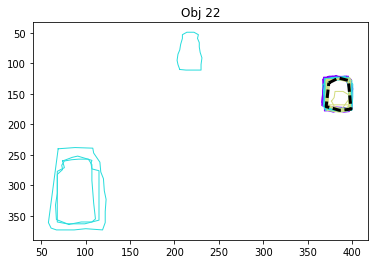

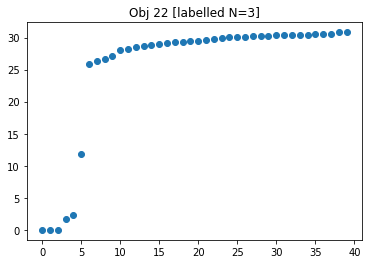

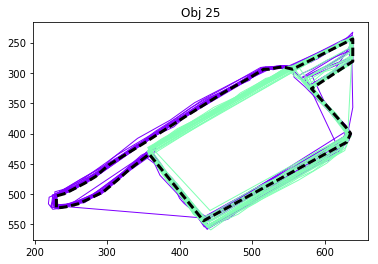

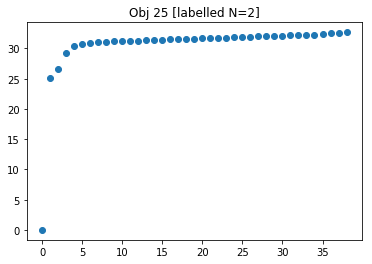

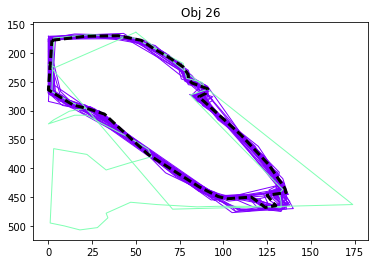

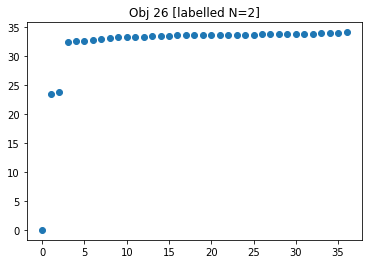

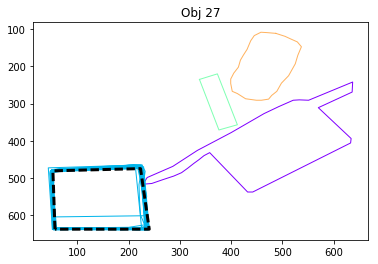

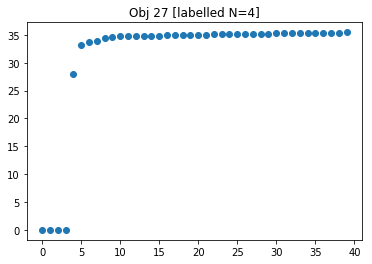

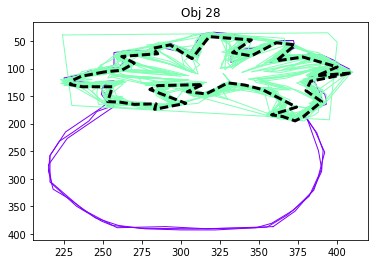

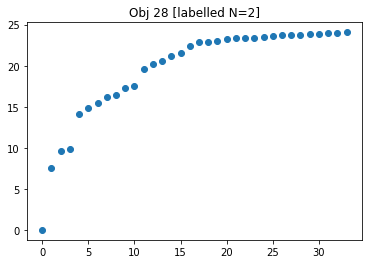

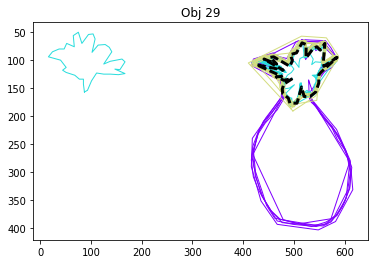

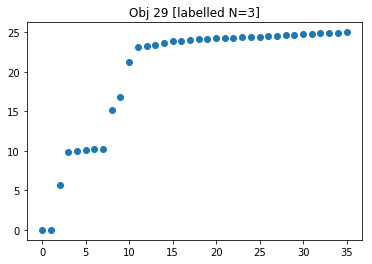

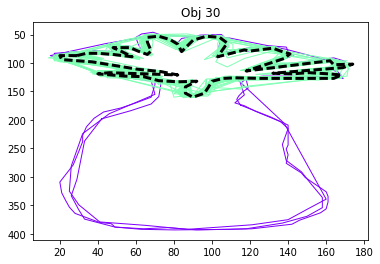

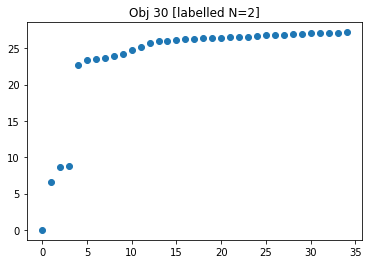

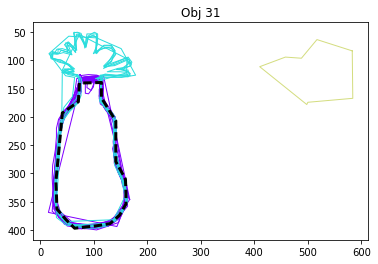

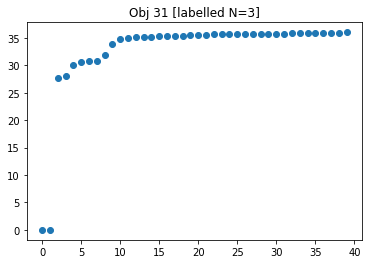

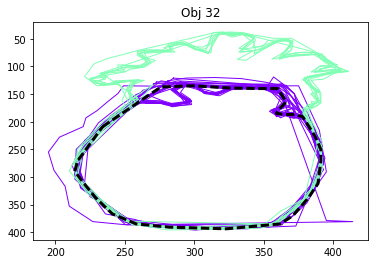

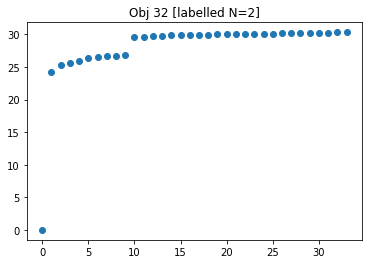

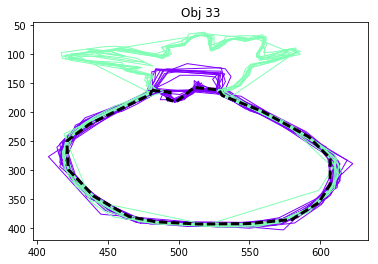

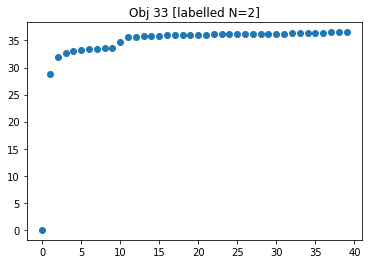

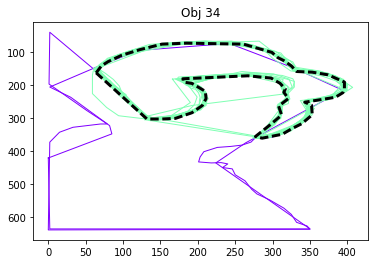

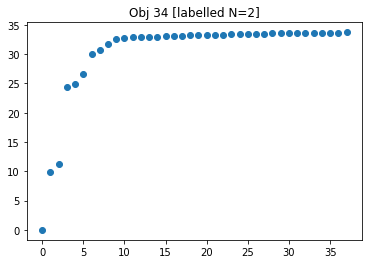

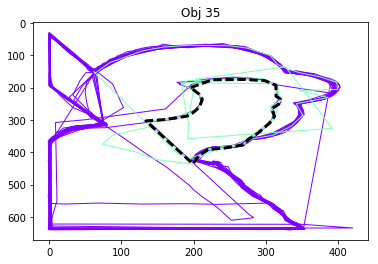

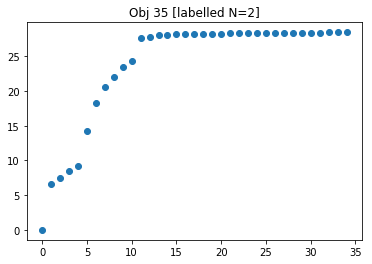

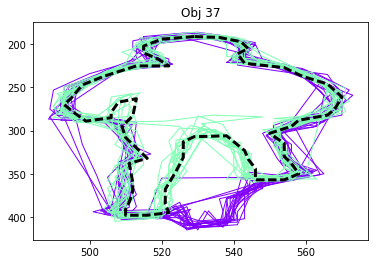

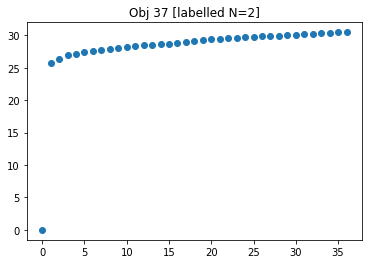

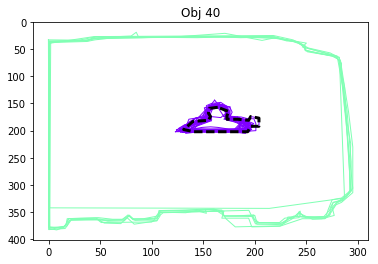

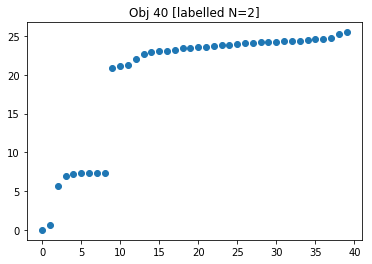

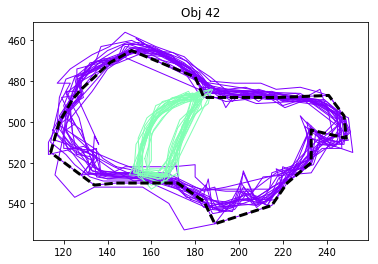

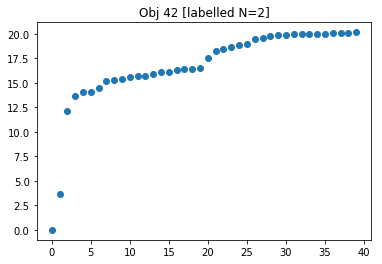

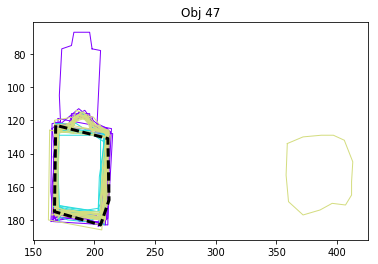

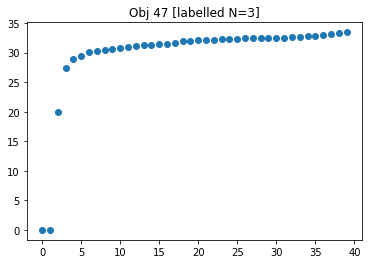

In [53]:
obj_worker_clusters =[]
for objN in objN_lst:
    obj_worker_cluster = run_spectral_clustering(objN[0],objN[1])
    obj_worker_clusters.extend(obj_worker_cluster)

In [61]:
df = pd.DataFrame(obj_worker_clusters,columns=["objid","wid","cluster"])

In [63]:
df.to_csv("spectral_clustering_all_hard_obj.csv",index=None)

# Now we are trying to automatically find number of clusters that is optimal for spectral clustering

In [211]:
average_J  =[]
for obj in easy_tasks:
    aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)
    average_J.append(aff_mat.mean())

In [262]:
print mean(average_J)
print min(average_J)

0.868359661538
0.742936675345


In [213]:
hard_average_J  =[]
for obj in all_hard_tasks:
    aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)
    hard_average_J.append(aff_mat.mean())

In [261]:
print mean(hard_average_J)
print max(hard_average_J)

0.724859030342
0.910496456622


In order to determine number of cluster we need to determine: 
1. Should this object be clustered or not?  --> Silhouette coefficient undefined if only single cluster, so use heuristic: if average Jaccard between all worker pairs are < threshold, then it should be clustered. (This heuristic is doing badly, it is clustering stuff that is not supposed to be clustered, and not clustering stuff that needs to be clustered, because as we can see above, the jaccard borderline between hard/easy objects is blurry (can PR help here?)
2. If it should be clustered, how many clusters (k) should it be? --> pick k s.t. maximize silhouette coefficient

In [40]:
def run_spectral_clustering_with_aff_mat(obj,N,aff_mat,worker_lst,PLOT=True):
    spectral = cluster.SpectralClustering(
            n_clusters=N, eigen_solver='arpack',
            affinity="precomputed")
    labels = spectral.fit_predict(aff_mat)
    if PLOT: 
        bb_objects = bb_info[bb_info["object_id"]==obj]
        plt.figure()
        plt.title("Obj {}".format(obj))
        cmap = plt.cm.rainbow
        for i,ylabel in enumerate(list(set(labels))):
            c = cmap(i / float(len(list(set(labels)))))
            workers_in_cluster = np.where(labels==ylabel)[0]
            for widx in workers_in_cluster:
                plot_coords(worker_polygon(bb_objects,worker_lst[widx]),reverse_xy=True,color=c,fill_color="")
        plot_coords(ground_truth_T(obj),color="black",fill_color="",reverse_xy=True,lw=3,linestyle='--',invert_y=True)
        plot_and_compute_laplacian_eigenval(obj,aff_mat,N)

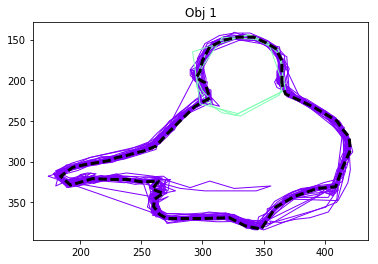

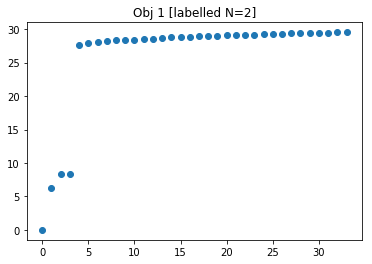

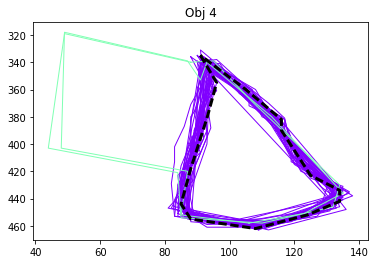

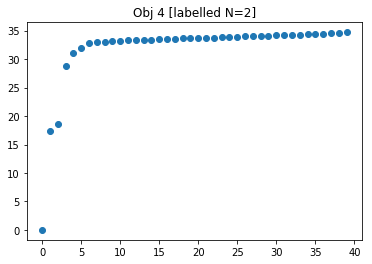

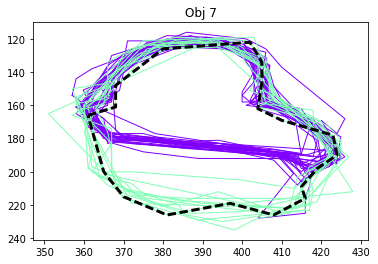

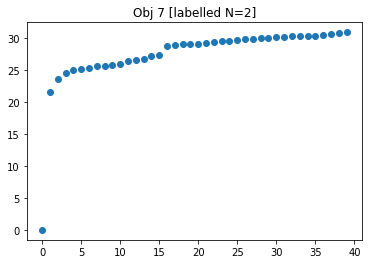

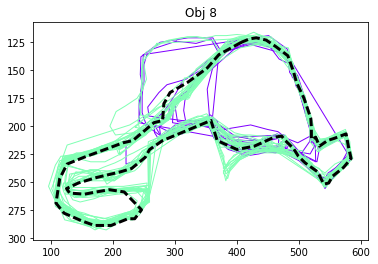

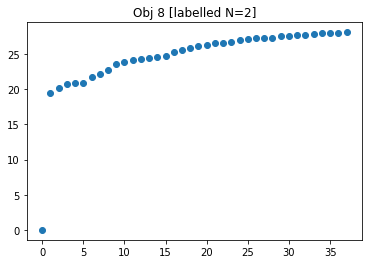

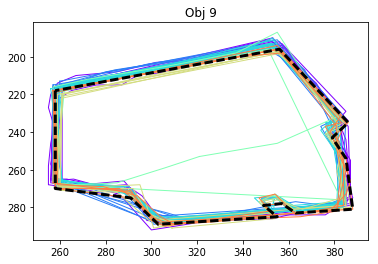

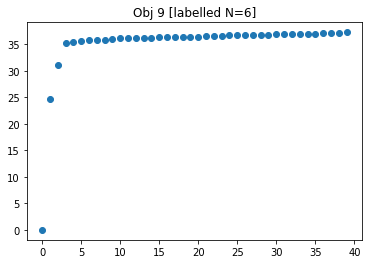

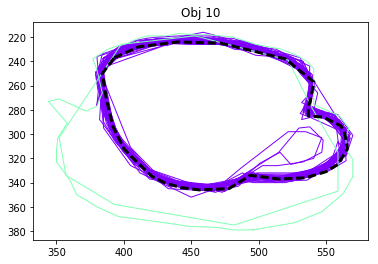

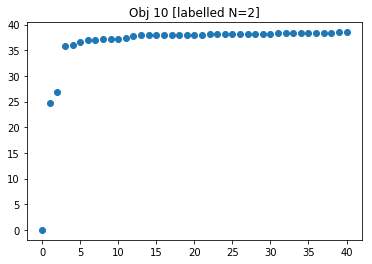

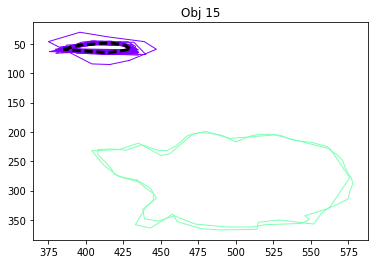

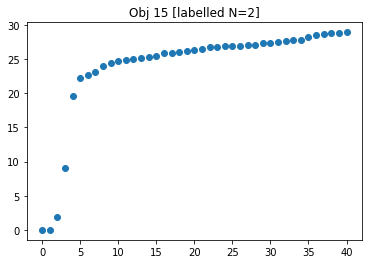

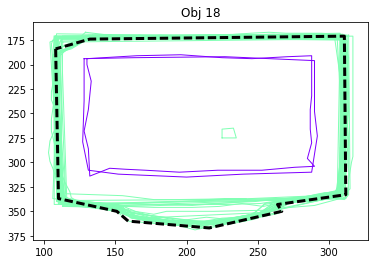

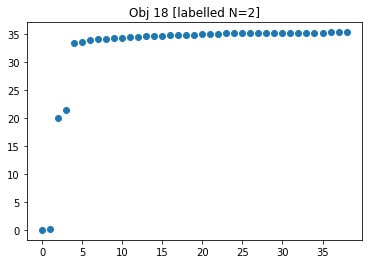

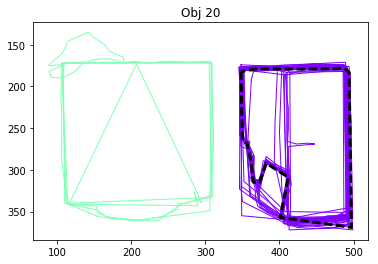

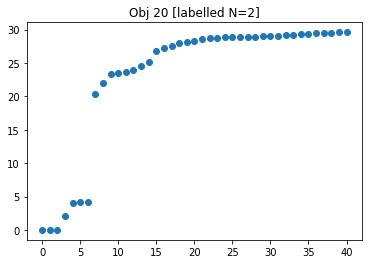

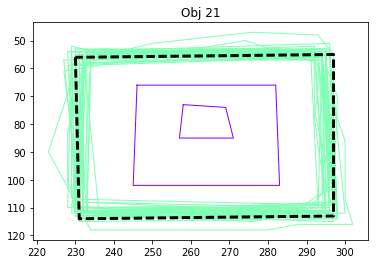

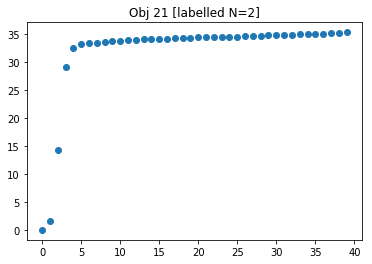

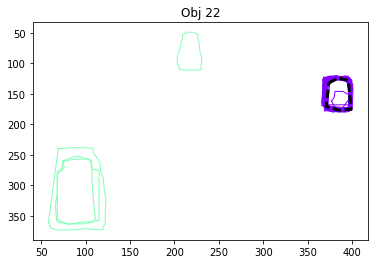

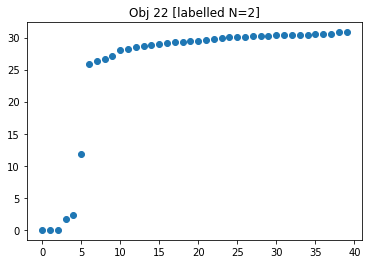

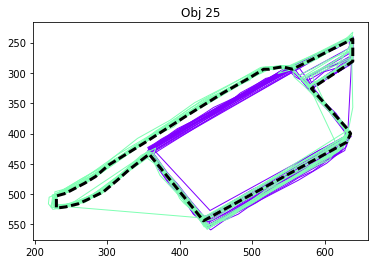

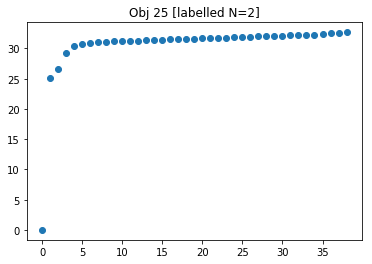

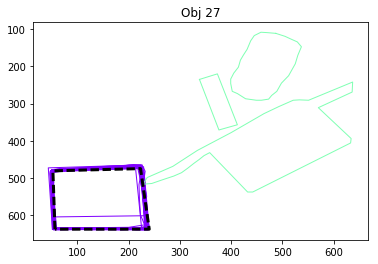

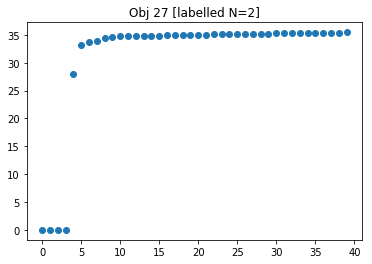

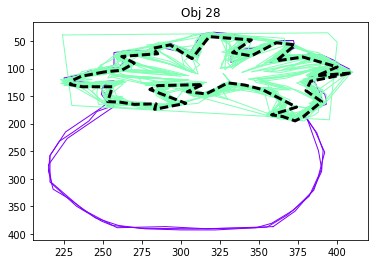

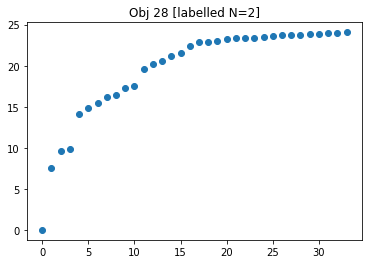

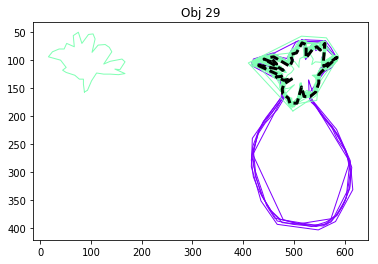

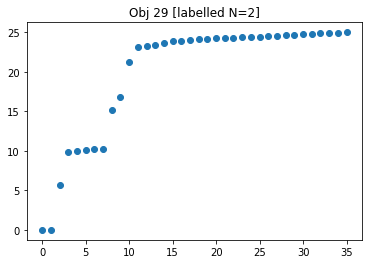

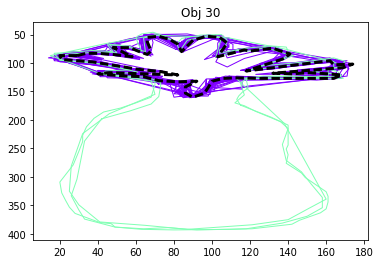

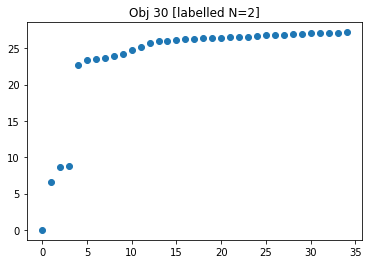

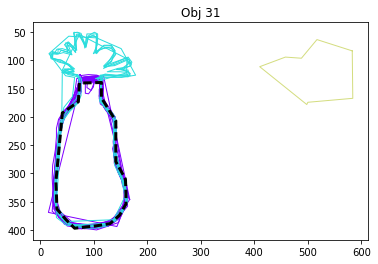

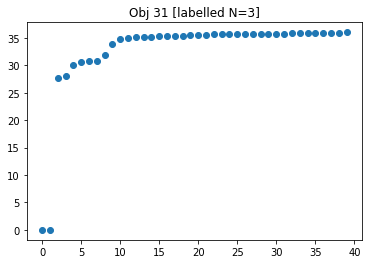

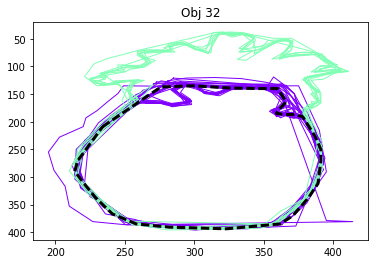

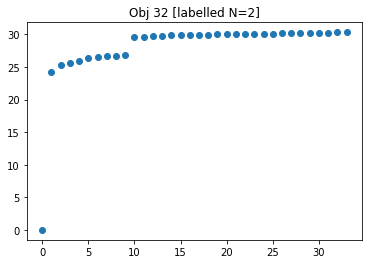

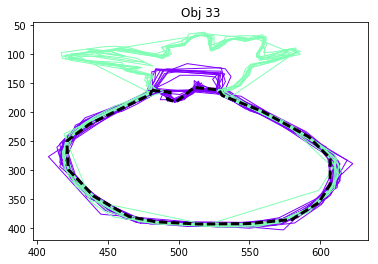

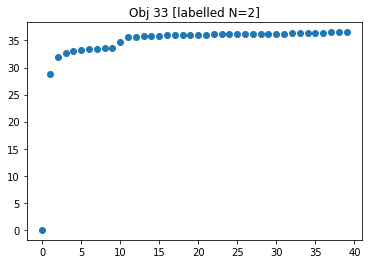

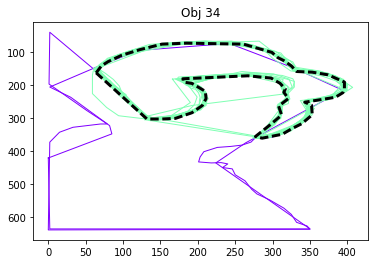

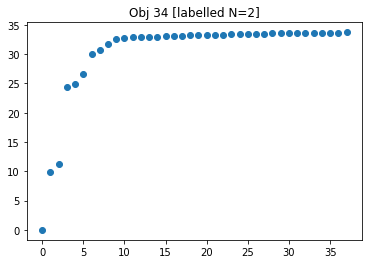

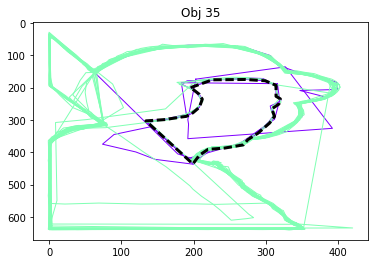

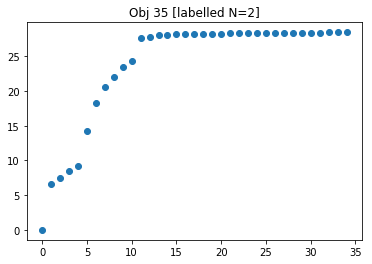

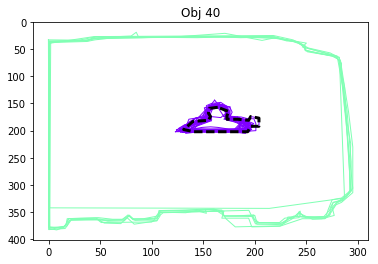

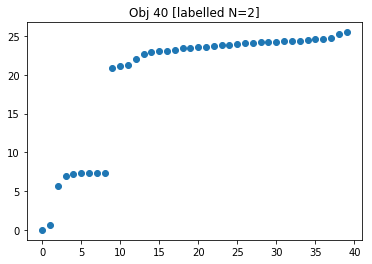

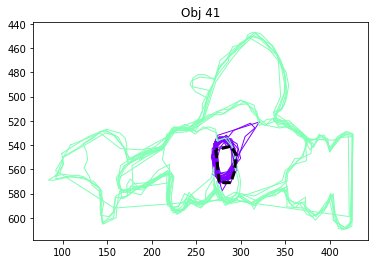

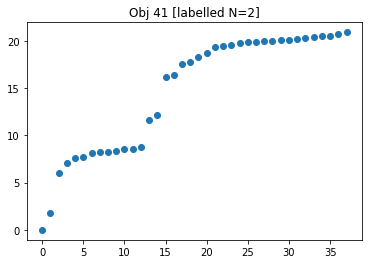

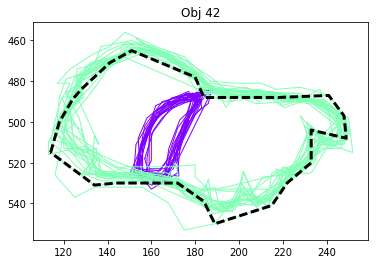

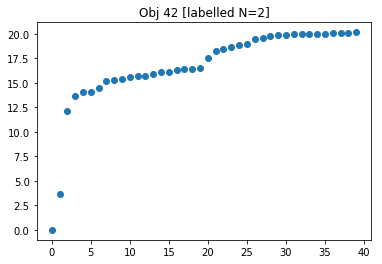

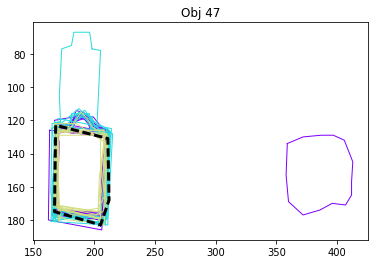

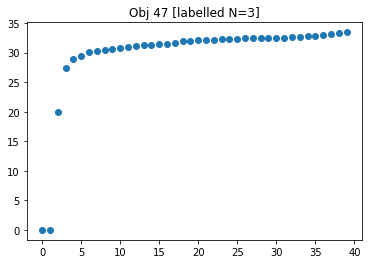

In [41]:
objN_lst_auto = []
for obj in all_hard_tasks:#object_lst:
#     aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)
    aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)
#     if aff_mat.mean() < 0.8:  
    # if average jaccard is lower 
    silst =[]
    cluster_to_test=[2,3,4,5,6,7]
    for N in cluster_to_test:
        if N==1:
            labels = np.ones((len(aff_mat),))
        else:
            spectral = cluster.SpectralClustering(
                        n_clusters=N, eigen_solver='arpack',
                        affinity="precomputed")
            labels = spectral.fit_predict(aff_mat)
        cluster_centers = []
        for i,ylabel in enumerate(list(set(labels))):
            workers_in_cluster = np.where(labels==ylabel)[0]
            cluster_centers.append(aff_mat[:,workers_in_cluster][workers_in_cluster].mean())
#             print cluster_centers
#             print average(cluster_centers)
#             print max(cluster_centers)
#             max_cluster_centers.append(max(cluster_centers))
#         #     print max(cluster_centers)
        silst.append(sklearn.metrics.silhouette_score(aff_mat,labels))
    best_cluster = np.argmax(silst)
    N=cluster_to_test[best_cluster]
    run_spectral_clustering_with_aff_mat(obj,N,aff_mat,worker_lst)
    objN_lst_auto.append((obj,N))
# else:
#     print "no need to cluster obj",obj

In [57]:
print objN_lst
print "------"
print objN_lst_auto

[(1, 2), (4, 2), (7, 2), (8, 3), (10, 2), (20, 5), (15, 2), (18, 4), (21, 2), (22, 3), (25, 2), (26, 2), (27, 4), (28, 2), (29, 3), (30, 2), (31, 3), (32, 2), (33, 2), (34, 2), (35, 2), (37, 2), (40, 2), (42, 2), (47, 3)]
------
[(1, 2), (4, 2), (7, 2), (8, 2), (9, 6), (10, 2), (15, 2), (18, 2), (20, 2), (21, 2), (22, 2), (25, 2), (27, 2), (28, 2), (29, 2), (30, 2), (31, 3), (32, 2), (33, 2), (34, 2), (35, 2), (40, 2), (41, 2), (42, 2), (47, 3)]


In [10]:
def spectral_coord(aff_mat, k):
    aff_mat = aff_mat - np.eye(len(aff_mat))
    import pygsp
    g = pygsp.graphs.Graph(aff_mat)
    g.compute_fourier_basis()
    return g.U[:,1:k]

In [47]:
def better_spectral_clustering(obj,k):
    aff_mat,worker_lst = compute_jaccard_affinity_matrix(obj)

    worker_coord = spectral_coord(aff_mat,k)

    plt.scatter(worker_coord[:,0],worker_coord[:,1])

    kmeans = cluster.KMeans(k)

    labels =kmeans.fit_predict(worker_coord)

    bb_objects = bb_info[bb_info["object_id"]==obj]
    plt.figure()
    plt.title("Obj {}".format(obj))
    #         colors = ["blue","red","green","magenta","orange"]
    #         for i,ylabel in enumerate(list(set(labels))):
    cmap = plt.cm.rainbow
    for i,ylabel in enumerate(list(set(labels))):
        c = cmap(i / float(len(list(set(labels)))))
        workers_in_cluster = np.where(labels==ylabel)[0]
        for widx in workers_in_cluster:
            plot_coords(worker_polygon(bb_objects,worker_lst[widx]),reverse_xy=True,color=c,fill_color="")
    plot_coords(ground_truth_T(obj),color="black",fill_color="",reverse_xy=True,lw=3,linestyle='--',invert_y=True)


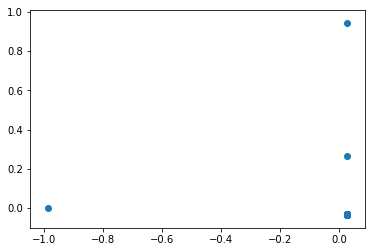

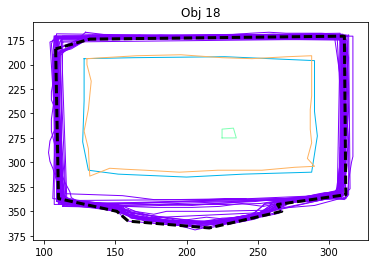

In [50]:
better_spectral_clustering(18,4)

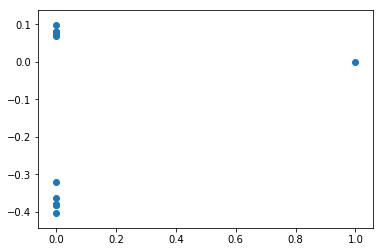

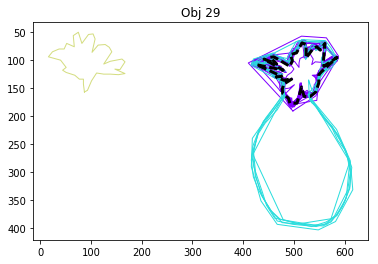

In [51]:
better_spectral_clustering(29,3)

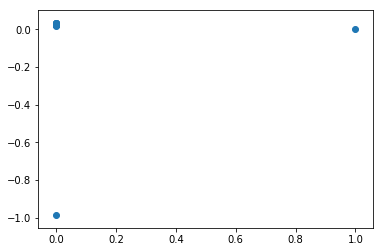

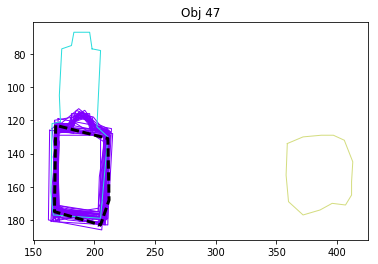

In [52]:
better_spectral_clustering(47,3)